In [2]:
dataset_id = "emotion"
model_id = "sentence-transformers/paraphrase-mpnet-base-v2"

In [ ]:
!pip install datasets

In [8]:
from datasets import load_dataset

reference_dataset = load_dataset(dataset_id)
reference_dataset

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [9]:
label_features = reference_dataset["train"].features["label"]
# Label names to classify with
candidate_labels = label_features.names
candidate_labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [10]:
def get_id2label(dataset):
    # The column with the label names
    label_names = dataset.unique("label_text")
    # The column with the label IDs
    label_ids = dataset.unique("label")
    id2label = dict(zip(label_ids, label_names))
    # Sort by label ID
    return {key: val for key, val in sorted(id2label.items(), key = lambda x: x[0])}



In [ ]:
!pip install setfit

In [18]:
from datasets import Dataset
from setfit import add_templated_examples

# A dummy dataset to fill with synthetic examples
dummy_dataset = Dataset.from_dict({})
train_dataset = add_templated_examples(dummy_dataset, candidate_labels=candidate_labels, sample_size=8)
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 48
})

In [19]:
train_dataset.shuffle()[:3]

{'text': ['This sentence is love',
  'This sentence is surprise',
  'This sentence is joy'],
 'label': [2, 5, 1]}

In [20]:
from setfit import SetFitModel

model = SetFitModel.from_pretrained(model_id)

Downloading:   0%|          | 0.00/594 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/594 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [21]:
from setfit import SetFitTrainer

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=reference_dataset["test"]
)

In [22]:
%%time
trainer.train()
zeroshot_metrics = trainer.evaluate()
zeroshot_metrics

***** Running training *****
  Num examples = 1920
  Num epochs = 1
  Total optimization steps = 120
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/120 [00:00<?, ?it/s]

***** Running evaluation *****


CPU times: user 19.3 s, sys: 2.98 s, total: 22.3 s
Wall time: 33.8 s


{'accuracy': 0.5415}

In [23]:
from transformers import pipeline

pipe = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [24]:
%%time
zeroshot_preds = pipe(reference_dataset["test"]["text"], batch_size=16, candidate_labels=candidate_labels)

CPU times: user 2min 24s, sys: 7.61 s, total: 2min 31s
Wall time: 2min 33s


In [25]:
zeroshot_preds[0]

{'sequence': 'im feeling rather rotten so im not very ambitious right now',
 'labels': ['sadness', 'anger', 'surprise', 'fear', 'joy', 'love'],
 'scores': [0.7367973327636719,
  0.10041780024766922,
  0.09770198166370392,
  0.058800872415304184,
  0.0042663393542170525,
  0.0020156814716756344]}

In [26]:
preds = [label_features.str2int(pred["labels"][0]) for pred in zeroshot_preds]

In [27]:
import evaluate

metric = evaluate.load("accuracy")
transformers_metrics = metric.compute(predictions=preds, references=reference_dataset["test"]["label"])
transformers_metrics

{'accuracy': 0.3765}

In [28]:
from setfit import sample_dataset

train_dataset = sample_dataset(reference_dataset["train"])
train_dataset

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 48
})

In [29]:
model = SetFitModel.from_pretrained(model_id)

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=reference_dataset["test"]
)
trainer.train()
fewshot_metrics = trainer.evaluate()
fewshot_metrics

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1920
  Num epochs = 1
  Total optimization steps = 120
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/120 [00:00<?, ?it/s]

***** Running evaluation *****


{'accuracy': 0.471}

In [30]:
augmented_dataset = add_templated_examples(train_dataset, candidate_labels=candidate_labels, sample_size=8)
augmented_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 96
})

In [31]:
model = SetFitModel.from_pretrained(model_id)

trainer = SetFitTrainer(
    model=model,
    train_dataset=augmented_dataset,
    eval_dataset=reference_dataset["test"]
)
trainer.train()
augmented_metrics = trainer.evaluate()
augmented_metrics

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 3840
  Num epochs = 1
  Total optimization steps = 240
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/240 [00:00<?, ?it/s]

***** Running evaluation *****


{'accuracy': 0.578}

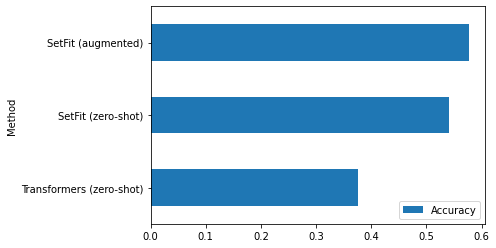

In [32]:
import pandas as pd

df = pd.DataFrame.from_dict({"Method":["Transformers (zero-shot)", "SetFit (zero-shot)", "SetFit (augmented)"], "Accuracy": [transformers_metrics["accuracy"], zeroshot_metrics["accuracy"], augmented_metrics["accuracy"]]})
df.plot(kind="barh", x="Method"); 